# Application of Tensor Decompositions
[Return to Table of Contents](./0_Table_of_contents.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports for classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Utils for this tutorial
from ijcnn import print_basic_metrics
from ijcnn.io import ETH80, plot_tensors

#
from hottbox import __version__ as hottbox_version
print("HOTTBOX version: {}".format(hottbox_version))

# Initialise dataset
eth = ETH80()

HOTTBOX version: 0.3.1


# Tucker representation

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$

Essentially, this means that the original data, $\mathbf{\underline{X}}$, is compressed into a dense core tensor, $\mathbf{\underline{G}}$, of much smaller size. The inverse of this operation is projection of a core tensor onto the subspaces spanned by the corresponding factor matrices, $\mathbf{A}, \mathbf{B}, \mathbf{C}$.

On practice, there exist several computational methods to represent N-dimensional array in Tucker form. Such algorithms are combined into one framework, namely the Tucker Decomposition. Here we will consider one of the most commonly used implementation: Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))

## Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


## Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

Tucker representation of a tensor with multi-linear rank=(25, 25, 2).
Factor matrices represent properties: ['pixel-X', 'pixel-Y', 'color']
With corresponding latent components described by (128, 128, 3) features respectively.

Basic metrics:
--------------
Compression rate = 6.42

Relative error of approximation = 5.89%



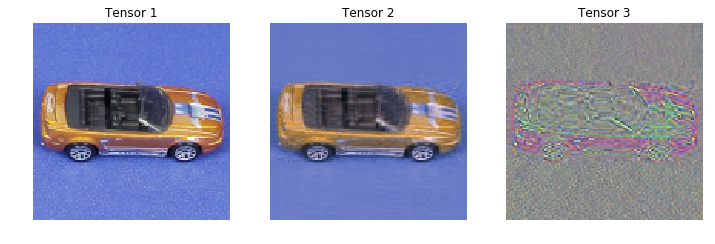

In [4]:
from hottbox.algorithms.decomposition import HOSVD
from hottbox.utils.generation import residual_tensor

data, _ = eth.get_samples(objects=["car"],
                          angle_1=["045"],
                          angle_2=["000"])

# Select only one sample, try out different samples, e.g. [3]
tensor = data[0]

# Set desired multi-linear rank, try out different values, e.g. (25, 25, 1)
ml_rank = (25, 25, 2)

# Initialise decomposition algorithm
algorithm = HOSVD()

# Perform compression via HOSVD
tensor_tkd = algorithm.decompose(tensor, rank=ml_rank, keep_meta=True)

# Perform reconstruction
tensor_reconstructed = tensor_tkd.reconstruct()

# Obtaion residual part
tensor_residual = residual_tensor(tensor, tensor_tkd)

# Preview results
print_basic_metrics(tensor, tensor_tkd)
plot_tensors([tensor, tensor_reconstructed, tensor_residual])

# Appllication: Tensor Ensemble Learning

<img src="./imgs/wisdom_of_the_crowd.png" alt="Drawing" style="width: 500px;"/>

The phenomenon of the wisdom of the crowd has been known for a very long time. The machine learning community have adopted this concept under the framework of **ensemble learning**. Key points:
- Every predictor should perform better than a random guess
- The errors of individual predictors should be uncorrelated
- Heterogeneous set of base learning algorithms - diversity of the individual hypotheses
- Homogeneous set of base classifiers and exposing each member to a subset of the training data

<div style="font-size:1.7em;">Ensemble Learning</div>  | | | <div style="font-size:1.7em;">Tensor Ensemble Learning</div>
:--- | --- | ---:
<img src="./imgs/EL_model_generation.png" alt="Drawing" style="width: 500px;"/> | $\Longleftrightarrow$ | <img src="./imgs/TEL_training_stage.png" alt="Drawing" style="width: 500px;"/>

<div style="text-align:center">
    <span style="color:blue; font-family:Georgia; font-size:1.7em;">
        Ensemble Learning + Tensor Decompositions = Tensor Ensemble Learning
    </span>
</div>


<img src="./imgs/TEL_general_concept.png" alt="Drawing" style="width: 400px;"/>

Implementation notes:
- For convenience, Stage 1 is performed on the whole batch of samples, but for each sample separately. Can be implemented in an online manner.
- Stage 2 and 3 are connected, therefore for simplification it is hidden from the end user  (so as Stage 4). Instead, we provide a top level API (similar to [**scikit-learn**](https://scikit-learn.org/stable/index.html)).
- Base classifiers could be anything, but there are two main requirements: 
    1. Their number should correspond to the decomposition (multi-linear rank) employed at Stage 1.
    1. They should have **scikit-liearn** type API, that is:
    ```python
    base_clf.fit(X, y)
    base_clf.predict(X)
    base_clf.predict_proba(X)
    ```


In [5]:
from hottbox.algorithms.decomposition import HOSVD
from hottbox.algorithms.classification import TelVI

# Get original multi-dimensional samples
# data, labels = eth.get_samples(objects=["dog", "car"], angle_1=["000"], angle_2=["000"])
# data, labels = eth.get_samples(["dog", "car"], ["045"], [])
data, labels = eth.get_samples(["dog", "car"], [], [])

# Represent each sample in Tucker form and store it in a list
algorithm = HOSVD()
ml_rank = (5, 5, 2)
data_transformed = [algorithm.decompose(sample, rank=(5, 5, 2)) for sample in data]

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(data_transformed, labels, test_size=0.2, random_state=42)

# Initialise classifier
base_clf_required = np.sum(ml_rank)
telvi = TelVI(base_clf=[SVC(gamma='auto') for _ in range(base_clf_required)],
              probability=True,
              verbose=True)

# Train classifer
telvi.fit(X_train, y_train)
score = telvi.score(X_test, y_test)
print("Classification accuracy: {:.2f}%\n".format(score * 100))

Base classifier #0 (SVC): Learning model parameters
Base classifier #1 (SVC): Learning model parameters
Base classifier #2 (SVC): Learning model parameters
Base classifier #3 (SVC): Learning model parameters
Base classifier #4 (SVC): Learning model parameters
Base classifier #5 (SVC): Learning model parameters
Base classifier #6 (SVC): Learning model parameters
Base classifier #7 (SVC): Learning model parameters
Base classifier #8 (SVC): Learning model parameters
Base classifier #9 (SVC): Learning model parameters
Base classifier #10 (SVC): Learning model parameters
Base classifier #11 (SVC): Learning model parameters
Classification accuracy: 51.22%



## Tuning hyperparameters of the base classifiers

In [6]:
search_params = [dict(gamma=[0.001, 0.01, 1, 10], C=[0.1, 1, 10, 100]) for _ in range(12)]

print("\n\tPerforming grid search for each base classifer")
telvi.grid_search(X_train, y_train, search_params)

print("\n\tTrain base classifiers with optimal hyperparameters")
telvi.fit(X_train, y_train)

score = telvi.score(X_test, y_test)
print("\nClassification accuracy: {:.2f}%\n".format(score * 100))


	Performing grid search for each base classifer
Base classifier #0 (SVC): Tuning the hyperparameters
Base classifier #1 (SVC): Tuning the hyperparameters
Base classifier #2 (SVC): Tuning the hyperparameters
Base classifier #3 (SVC): Tuning the hyperparameters
Base classifier #4 (SVC): Tuning the hyperparameters
Base classifier #5 (SVC): Tuning the hyperparameters
Base classifier #6 (SVC): Tuning the hyperparameters
Base classifier #7 (SVC): Tuning the hyperparameters
Base classifier #8 (SVC): Tuning the hyperparameters
Base classifier #9 (SVC): Tuning the hyperparameters
Base classifier #10 (SVC): Tuning the hyperparameters
Base classifier #11 (SVC): Tuning the hyperparameters

	Train base classifiers with optimal hyperparameters
Base classifier #0 (SVC): Learning model parameters
Base classifier #1 (SVC): Learning model parameters
Base classifier #2 (SVC): Learning model parameters
Base classifier #3 (SVC): Learning model parameters
Base classifier #4 (SVC): Learning model parameters

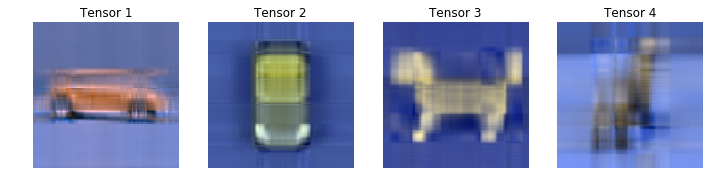

In [7]:
# Preview of original and transformed samples
plot_tensors([X_train[0].reconstruct(),
              X_train[1].reconstruct(),
              X_test[0].reconstruct(),
              X_test[1].reconstruct()
             ])

# Utilities for interacting with ETH-80 dataset

[**ETH-80 dataset**](https://www.mpi-inf.mpg.de/departments/computer-vision-and-multimodal-computing/research/object-recognition-and-scene-understanding/analyzing-appearance-and-contour-based-methods-for-object-categorization/) consists of 3280 colour images (128×128 pixels) from 8 categories: *apple, car, cow, cup, dog, horse, pear, tomato*. Each category contains 10 different objects with 41 views per object, spaced equally over the
viewing hemisphere. For ease of interaction with this dataset we provide you with `ETH80` class and some other utility functions (source code could be found [here](../ijcnn/ijcnn/io.py)).

Interaction with the dataset include two main steps.
- Initialisation of the dataset (can be done only once)
- Obtaining samples of interest and corresponding labels

```python
# Initialise dataset
eth = ETH80()

# By default returns all available samples
# as a list of 'Tensor' objects and array of labels
data, labels = eth.get_samples()
```

In order to work with only a portion of the dataset, you can pass parameters to `get_samples()`. To see all available options use the following properties of the `ETH80` class

```python
# List of object names
eth.available_objects

# List of angle pairs
eth.available_angle_pairs
```

Number of samples: 40



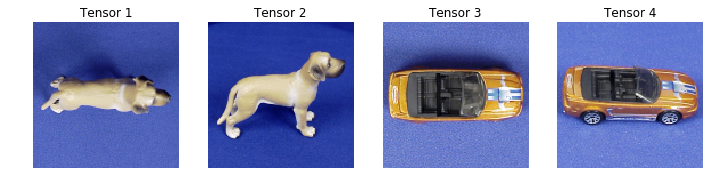

In [8]:
# Select only a portion of the whole dataset
data, labels = eth.get_samples(objects=["car", "dog"], 
                               angle_1=["000", "045"], 
                               angle_2=["000"])
print("Number of samples: {}\n".format(len(data)))
plot_tensors(data)

Alternatively, you can inspect meta data this data set with the use of `meta_data` property of `ETH80` class, which returns a [pandas dataframe](https://www.geeksforgeeks.org/python-pandas-dataframe/).

In [9]:
eth.meta_data.head()

,Angle_1,Angle_2,Label,Object,id
0,066,027,5,dog5,dog5-066-027
1,068,180,5,dog5,dog5-068-180
2,066,117,5,dog5,dog5-066-117
3,035,315,5,dog5,dog5-035-315
4,000,000,5,dog5,dog5-000-000
